In [43]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import math
from sklearn.linear_model import LinearRegression
import argparse
from PIL import Image
from random import random

import matplotlib.image as mpimg 
import skimage
import scipy
from scipy import ndimage

%matplotlib inline

class Vertex:
    def __init__(self, parent, rank=0, size=1):
        self.p = parent
        self.r = rank
        self.s = size
        
class Universe:
    def __init__(self, num_v):
        self.v = [Vertex(i) for i in range(num_v)]
        self.num_v = num_v

    def size(self, i):
        return self.v[i].s

    def find(self, n):
        temp = n
        while temp != self.v[temp].p:
            temp = self.v[temp].p
        self.v[n].p = temp
        return temp

    def union(self, a, b):
        if self.v[a].r > self.v[b].r:
            self.v[b].p = a
            self.v[a].s += self.v[b].s
        else:
            self.v[a].p = b
            self.v[b].s += self.v[a].s
            if self.v[a].r == self.v[b].r:
                self.v[b].r += 1
        self.num_v -= 1
        
def read_image(IMG_NAME):
    img = cv2.imread(IMG_NAME)
    return cv2.resize(img, (480, 360))

def threshold_func(size, k):
    return (k * 1.0 / size)

def build(img):
    h, w, _ = img.shape
    edges = []
    
    def create_edge(img, x, y, x1, y1):
        def vertex(x, y):
            return x * w + y
        return (vertex(x, y), vertex(x1, y1), np.sqrt(np.sum((img[x, y] - img[x1, y1]) ** 2)))

    for x in range(h):
        for y in range(w):
            if x > 0:
                edges.append(create_edge(img, x, y, x-1, y))
            if y > 0:
                edges.append(create_edge(img, x, y, x, y-1))
            if x > 0 and y > 0:
                edges.append(create_edge(img, x, y, x-1, y-1))
            if x > 0 and y < h-1:
                edges.append(create_edge(img, x, y, x-1, y+1))

    return edges

def generate_image(u, w, h):
    random_color = lambda: (int(random()*255), int(random()*255), int(random()*255))
    colors = [random_color() for i in range(w*h)]

    img = Image.new('RGB', (h, w))
    im = img.load()
    for x in range(h):
        for y in range(w):
            comp = u.find(x * w + y)
            im[x, y] = colors[comp]

    return img.transpose(Image.ROTATE_270).transpose(Image.FLIP_LEFT_RIGHT)


def open_img(img):
    image = cv2.imread(img)
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    return image

def open_img_color(img):
    image = cv2.imread(img)
    return image

def show_image_color(img):
    temp = img[:,:,-1]
    img[:,:,-1] = img[:,:,0]
    img[:,:,0] = temp
    plt.figure(figsize = (8,8))
    plt.imshow(img)
    plt.show()
    
def show_image_gray(img):
    plt.imshow(img,  cmap='gray')
    plt.show()
    
def do_erode(img,iteration):
    kernel = np.ones((5,5),np.uint8)
    erosion = cv2.erode(img,kernel,iterations = iteration)
    return erosion

def do_dilate(img,iteration):
    #https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_morphological_ops/py_morphological_ops.html
    kernel = np.ones((5,5),np.uint8)
    dilation = cv2.dilate(img,kernel,iterations = iteration)
    return dilation

def filtered_white(img,low_white,high_white):
    mask_white = cv2.inRange(img, low_white, high_white)
    img = cv2.bitwise_and(img, mask_white)
    kernel_size = 5
    gauss_gray = cv2.GaussianBlur(img,(kernel_size,kernel_size),0)
    #show_image_gray(gauss_gray)
    return gauss_gray

def ROI(img):
    h,w = img.shape[0],img.shape[1]
    #print(h)
    #print(w)
    triangle = np.array([[(49,h),(429,h),(250,100)]])
    mask = np.zeros_like(img)
    cv2.fillPoly(mask,triangle,255)
    #show_image_gray(mask)
    masked_image = cv2.bitwise_and(img,mask)
    return masked_image

def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged

def find_x_coordinate(img,param):
    #print(param)
    slope,intercept = param
    
    y1 = img.shape[0]
    y2 = int(y1*(2/5))
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return np.array([x1,y1,x2,y2])
def find_and_draw_lines(original_img,lines):
    combo_img = original_img.copy()
    left_line = []
    right_line = []
    for line in lines:
        x1,y1,x2,y2 = line.reshape(4)
        x = [x1,x2]
        y = [y1,y2]
       # print("x {}".format(x))
        #print("y {}".format(y))
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        #print(intercept)
        param = [slope, intercept]
        #param = np.polyfit((x1,x2),(y1,y2),1)
        #slope = param[0]
        if math.isnan(slope) == False and math.isnan(intercept) == False:
            if slope < -0.8:
                left_line.append(param)
            elif slope > 0.8:
                right_line.append(param)
    
    l_line = list()
    r_line = list()
    line_img = np.zeros_like(original_img)
    if len(left_line) != 0:    
        left_line_avg = np.mean(left_line,axis = 0)
        l_line = find_x_coordinate(img,left_line_avg)
        cv2.line(line_img,(l_line[0],l_line[1]),(l_line[2],l_line[3]),(0,255,0),5)
    if len(right_line) != 0:
        right_line_avg = np.mean(right_line,axis = 0)
        r_line = find_x_coordinate(img,right_line_avg)
        cv2.line(line_img,(r_line[0],r_line[1]),(r_line[2],r_line[3]),(0,255,0),5)

    combo_img = cv2.addWeighted(original_img,1,line_img,1,1)
    return combo_img
    #print(left_line_avg)

def get_slope(x1,y1,x2,y2):
    return (y2-y1)/(x2-x1)
def find_draw_best_lines(original_img,lines):
    combo_img = original_img.copy()
    l_line = []
    r_line = []
    for line in lines:
        #print(line)
        det_slope = 0.8
        x1,y1,x2,y2 = line.reshape(4)
        slope = get_slope(x1,y1,x2,y2)
        if slope < -det_slope:
            l_line.append(x1)
            l_line.append(y1)
            l_line.append(x2)
            l_line.append(y2)
        elif slope > det_slope:
            r_line.append(x1)
            r_line.append(y1)
            r_line.append(x2)
            r_line.append(y2)

        if len(l_line) != 0 and len(r_line) != 0:
            line_img = np.zeros_like(original_img)
            cv2.line(line_img,(l_line[0],l_line[1]),(l_line[2],l_line[3]),(0,255,0),5)
            cv2.line(line_img,(r_line[0],r_line[1]),(r_line[2],r_line[3]),(0,255,0),5)
            combo_img = cv2.addWeighted(original_img,1,line_img,1,1)
            return combo_img
    return combo_img


def hough_lines(original_img, img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    if lines is None:
        return original_img
    if len(lines) == 0:
        return
    combo_img = find_draw_best_lines(original_img.copy(),lines)
    #combo_img = find_and_draw_lines(original_img.copy(),lines)
    return combo_img

def find_contour(color_img,img,line_threshold):
    left_points = []
    right_points = []
    ### to find the image contour...
    ret,thresh = cv2.threshold(img,127,255,0)
    im2, contours, hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    #print(np.asarray(contours).shape)
    for i in contours:
        #box, with x,y and with height
        bx,by,bw,bh = cv2.boundingRect(i)
        if bw > line_threshold:
            cv2.line(color_img,(bx,by),(bx+bw,by),(0,255,0),3)
            left_points.append([bx,by])
            right_points.append([bx+bw,by])
            cv2.circle(color_img,(bx,by),2,(0,0,255),5)
            cv2.circle(color_img,(bx+bw,by),2,(0,0,255),5)
    #cv2.drawContours(color_img, contours, -1, (0,255,0), 3)
    #show_image_color(color_img)
    left_points = np.asarray(left_points)
    right_points = np.asarray(right_points)
    return img,left_points,right_points

def find_equation(img, slope, intercept):
    h = img.shape[0]
    y1 = h
    y2 = int(h/5)
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    return np.array([x1,y1,x2,y2])

def fit_and_draw(img, left_points, right_points,img_box):
    det_slope = 0.8
    l_slope, l_intercept, l_r_value, l_p_value, l_std_err = None,None,None,None,None
    r_slope, r_intercept, r_r_value, r_p_value, r_std_err = None,None,None,None,None
    combo_img = img.copy()
    line_img = np.zeros_like(combo_img)
    if len(left_points) != 0:
        #l_slope, l_intercept, l_r_value, l_p_value, l_std_err = stats.linregress(left_points[:,0],left_points[:,1])
        reg = LinearRegression()  # create object for the class
        reg.fit(left_points[:,0].reshape(-1,1), left_points[:,1].reshape(-1,1)) 
        l_slope = reg.coef_[0][0]
        l_intercept = reg.intercept_[0]
        if math.isnan(l_slope) == False and math.isnan(l_intercept) == False and l_slope < -det_slope:
            l_fit = find_equation(img,l_slope,l_intercept)
            #print(l_fit)
            cv2.line(line_img,(l_fit[0],l_fit[1]),(l_fit[2],l_fit[3]),(255,0,0),3)
            
    if len(right_points) != 0:
        #r_slope, r_intercept, r_r_value, r_p_value, r_std_err = stats.linregress(right_points[:,0],right_points[:,1])
        reg = LinearRegression()  # create object for the class
        reg.fit(right_points[:,0].reshape(-1,1), right_points[:,1].reshape(-1,1)) 
        r_slope = reg.coef_[0][0]
        r_intercept = reg.intercept_[0]
        if math.isnan(r_slope) == False and math.isnan(r_intercept) == False and r_slope > det_slope:
            r_fit = find_equation(img,r_slope,r_intercept)
            #print(r_fit)
            cv2.line(line_img,(r_fit[0],r_fit[1]),(r_fit[2],r_fit[3]),(255,0,0),3)
    combo_img = cv2.addWeighted(img,1,line_img,1,1)
    return combo_img

def get_output_layers(net):
    
    layer_names = net.getLayerNames()
    
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

    return output_layers


def draw_prediction(img, class_id, confidence, x, y, x_plus_w, y_plus_h, state='nostate'):

    label = str(classes[class_id])

    color = COLORS[class_id]
    if label == 'traffic light' or label == 'stop sign':
        color = [0,0,255]
        cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 4)
    else:
        cv2.rectangle(img, (x,y), (x_plus_w,y_plus_h), color, 2)
    
    if state == 'nostate':
        cv2.putText(img, label, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    else:
        cv2.putText(img, state, (x-10,y-10), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 5)
        

def filterColors(img, box, threshold=0.015):
    
    # img = cv2.imread("light.jpg")
    # img = cv2.imread("sunflw.jpg")
    box_region = img[box[1]:box[3], box[0]:box[2]]
    box_hsv = cv2.cvtColor(box_region, cv2.COLOR_BGR2HSV)
    
    if box_hsv is None:
        return 'nostate'
    # lower mask (0-5) and upper mask (175-180) of RED
    red_mask1 = cv2.inRange(box_hsv, (0,90,20), (5,255,255))
    red_mask2 = cv2.inRange(box_hsv, (175,90,20), (180,255,255))
    # merge the mask and crop the red regions
    red_mask = cv2.bitwise_or(red_mask1, red_mask2)
    
    # mask of white
    white_mask = cv2.inRange(box_hsv, (0,0,180),(180,80,255))
#     plt.figure()
#     plt.imshow(white_mask)
    
#     plt.figure()
#     plt.imshow(red_mask)
    # compare
    white_perc = np.count_nonzero(np.array(white_mask)) / (white_mask.shape[0] * white_mask.shape[1])
    red_perc = np.count_nonzero(np.array(red_mask))/ (red_mask.shape[0] * red_mask.shape[1])

    if red_perc > threshold:
        return 'red'
    elif white_perc > threshold:
        return 'white'
    else:
        return 'nostate'

def img_seg(IMG_NAME):
    img = read_image(IMG_NAME)
    img = scipy.ndimage.gaussian_filter(img, sigma = sigma)
    edges = build(img)

    weight = lambda edge: edge[2]
    sorted_edges = sorted(edges, key=weight)
    h, w, _ = img.shape
    num_v = h*w
    u = Universe(num_v)
    threshold = [threshold_func(1, k) for _ in range(num_v)]

    for edge in sorted_edges:
            p_a = u.find(edge[0])
            p_b = u.find(edge[1])
            a_condition = weight(edge) <= threshold[p_a]
            b_condition = weight(edge) <= threshold[p_b]

            if p_a != p_b and a_condition and b_condition:
                u.union(p_a, p_b)
                a = u.find(p_a)
                threshold[a] = weight(edge) + threshold_func(u.v[a].s, k)

    for edge in sorted_edges:
        a = u.find(edge[0])
        b = u.find(edge[1])
        if a != b and (u.size(a) < min_size or u.size(b) < min_size):
            u.union(a, b)

    output = generate_image(u, w, h)
    output.save("sef2.jpg")

def ransac(points):
    pass


In [3]:
sigma = 1 
k = 8000 #prefer segment of larger size.
min_size = 5000 #a threshold for majorities of segments merging.

scale = 0.00392

classes = None

with open("yolov3.txt", 'r') as f:
    classes = [line.strip() for line in f.readlines()]

COLORS = np.random.uniform(0, 255, size=(len(classes), 3))

weights = "yolov3.weights"
config = "yolov3.cfg"

net = cv2.dnn.readNet(weights, config)


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

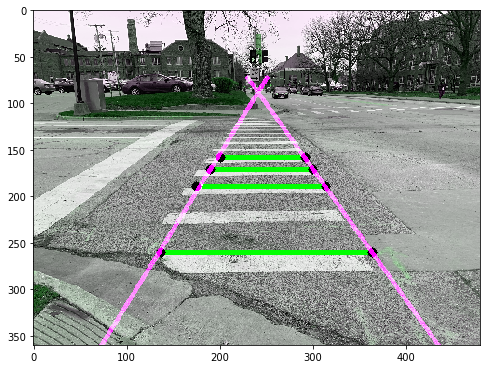

[(9600, 180)]
(9600, 180)


True

In [5]:
# entry point
image_name = "dataset/IMG_1.jpeg"
# image_name = "white.jpg"

image_orig = cv2.imread(image_name)
image = cv2.imread(image_name)

Width = image.shape[1]
Height = image.shape[0]
blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

net.setInput(blob)

outs = net.forward(get_output_layers(net))

class_ids = []
confidences = []
boxes = []
conf_threshold = 0.5
nms_threshold = 0.4


for out in outs:
    for detection in out:
        scores = detection[5:]
        class_id = np.argmax(scores)
        confidence = scores[class_id]
        if confidence > 0.5:
            center_x = int(detection[0] * Width)
            center_y = int(detection[1] * Height)
            w = int(detection[2] * Width)
            h = int(detection[3] * Height)
            x = center_x - w / 2
            y = center_y - h / 2
            class_ids.append(class_id)
            confidences.append(float(confidence))
            boxes.append([x, y, w, h])


indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

light_coord = []
stop_coord = []
red_found = False
white_found = False
for i in indices:
    i = i[0]
    box = boxes[i]
    x = box[0]
    y = box[1]
    w = box[2]
    h = box[3]
    
    if str(classes[class_ids[i]]) == "traffic light":
        light_box = [round(x), round(y), round(x+w), round(y+h)]
        light_coord.append(light_box)
        state = filterColors(image, light_box)
        if state == 'red':
            red_found = True
        elif state == 'white':
            white_found = True
        draw_prediction(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h), state) 
    elif str(classes[class_ids[i]]) == "stop sign":
        stop_coord.append(np.array([round(x), round(y), round(x+w), round(y+h)]))
        draw_prediction(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h)) 
    else:
        draw_prediction(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h)) 

cv2.imwrite("object-detection.jpg", image)
cv2.destroyAllWindows()

boximg = open_img_color("object-detection.jpg")

img = open_img('dataset/IMG_1.jpeg')
img = cv2.resize(img,(480,360))

#print(img.dtype)
img_c = open_img_color('dataset/IMG_1.jpeg')
img_c = image_orig
img_c = cv2.resize(img_c,(480,360))
# show_image_gray(img)
# show_image_color(img_c)
img = filtered_white(img,200,255)

# show_image_gray(img)
#img = cv2.Canny(img,50,100)
#show_image_gray(img)
#img = do_erode(img,2)
#img = do_dilate(img,3)
img = ROI(img)
img,left_points,right_points = find_contour(img_c,img,90)
combo_img = fit_and_draw(img_c,left_points,right_points,boximg)
show_image_color(combo_img)

boximg = cv2.resize(boximg,(1440,1080))
combo_img = cv2.resize(combo_img,(1440,1080))

temp = combo_img[:,:,2]
combo_img[:,:,2] = combo_img[:,:,0]
combo_img[:,:,0] = temp

combined = cv2.addWeighted(combo_img,0.5,boximg,0.5,1)


cv2.imwrite("combined_image.jpg", combined)

#-------------------------two line crosswalk
# img = tempimg
# img_color= tempimgc
# canny_img = cv2.Canny(img,100,150)
# show_image_gray(canny_img)
# img_roi = ROI(canny_img)
# rho = 4
# theta = np.pi/180
# threshold = 30
# min_line_len = 50
# max_line_gap = 50

# line_image = hough_lines(img_color,img_roi, rho, theta, threshold, min_line_len, max_line_gap)
# show_image_gray(line_image)

img_seg(image_name)

IMG_NAME = "sef2.jpg"
img = cv2.imread(IMG_NAME)

kernel = np.ones((2,2),np.uint8)
erosion = cv2.erode(img,kernel,iterations = 1)
plt.imsave("ero-" + IMG_NAME, erosion)

# identifer_x = 300
# identifer_y = 240
# walkable = erosion.copy()
# identifer = erosion[identifer_x, identifer_y]
# walkable[walkable != identifer] = 0
# walkable = cv2.cvtColor(walkable, cv2.COLOR_BGR2GRAY)
# walkable[walkable != 0] = 1
# kernel = np.ones((3,3),np.uint8)
# dilation = cv2.dilate(walkable,kernel,iterations = 1)
# plt.imsave("dwalk-" + IMG_NAME, dilation, cmap="gray")

erosion = cv2.cvtColor(erosion, cv2.COLOR_BGR2GRAY)
roi = erosion[300:360, 160:320]
im = Image.fromarray(roi)
plt.imsave("roi-" + IMG_NAME, roi)
w, h = im.size
colors = im.getcolors(w*h)
print(colors)
print(max(colors))
count, (c) = max(colors)
colors.remove((count, c))
if len(colors) > 0:
    _, (c2) = max(colors)
walkable = erosion.copy()
walkable[walkable == c] = 1
if len(colors) > 0:
    walkable[walkable == c2] = 1
walkable[walkable != 1] = 0
new_name = "walk-" + IMG_NAME
plt.imsave(new_name, walkable, cmap="gray")

show = plt.imread(new_name)
show = cv2.resize(show,(1440,1080))

blue = show[:,:,0] == 255
green = show[:,:,1] == 255
red = show[:,:, 2] == 255
show[blue, 0] = 255
show[green, 1] = 0
show[red,2] = 0

combined_side = cv2.addWeighted(show,0.2,boximg,0.8,1)
cv2.imwrite("combined_side_image.jpg", combined_side)

In [48]:
cap = cv2.VideoCapture('Sidewalk and crosswalk detection/test6.mp4')
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out_video = cv2.VideoWriter('test6_output.avi',fourcc, 30.0, (1440,1080))
while(cap.isOpened()):
    redflag = 0
    whiteflag = 0
    ret, frame = cap.read()
    if ret == False:
        break
    image_orig = frame.copy()
    image_orig_seg = frame.copy()
    image = frame
    Width = image.shape[1]
    Height = image.shape[0]
    blob = cv2.dnn.blobFromImage(image, scale, (416,416), (0,0,0), True, crop=False)

    net.setInput(blob)

    outs = net.forward(get_output_layers(net))

    class_ids = []
    confidences = []
    boxes = []
    conf_threshold = 0.5
    nms_threshold = 0.4


    for out in outs:
        for detection in out:
            scores = detection[5:]
            class_id = np.argmax(scores)
            confidence = scores[class_id]
            if confidence > 0.5:
                center_x = int(detection[0] * Width)
                center_y = int(detection[1] * Height)
                w = int(detection[2] * Width)
                h = int(detection[3] * Height)
                x = center_x - w / 2
                y = center_y - h / 2
                class_ids.append(class_id)
                confidences.append(float(confidence))
                boxes.append([x, y, w, h])


    indices = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)

    light_coord = []
    stop_coord = []
    red_found = False
    white_found = False
    for i in indices:
        i = i[0]
        box = boxes[i]
    
        x = box[0]
        y = box[1]
        w = box[2]
        h = box[3]

        if str(classes[class_ids[i]]) == "traffic light":
            light_box = [round(x), round(y), round(x+w), round(y+h)]
            light_coord.append(light_box)
            state = filterColors(image, light_box)
            #state = 'red'
            if state == 'red':
                red_found = True
                redflag = 1
            elif state == 'white':
                white_found = True
                whiteflag = 1
            draw_prediction(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h), state) 
        elif str(classes[class_ids[i]]) == "stop sign":
            stop_coord.append(np.array([round(x), round(y), round(x+w), round(y+h)]))
            draw_prediction(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h)) 
        else:
            draw_prediction(image, class_ids[i], confidences[i], round(x), round(y), round(x+w), round(y+h)) 

    cv2.destroyAllWindows()

    boximg = image

    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    img = cv2.resize(img,(480,360))

    #print(img.dtype)
    img_c = image_orig
    img_c = cv2.resize(img_c,(480,360))
    # show_image_gray(img)
    # show_image_color(img_c)
    img = filtered_white(img,200,255)

    # show_image_gray(img)
    #img = cv2.Canny(img,50,100)
    #show_image_gray(img)
    #img = do_erode(img,2)
    #img = do_dilate(img,3)
    img = ROI(img)
    img,left_points,right_points = find_contour(img_c,img,90)
    combo_img = fit_and_draw(img_c,left_points,right_points,boximg)

    boximg = cv2.resize(boximg,(1440,1080))
    combo_img = cv2.resize(combo_img,(1440,1080))

    temp = combo_img[:,:,2]
    combo_img[:,:,2] = combo_img[:,:,0]
    combo_img[:,:,0] = temp

    combined = cv2.addWeighted(combo_img,0.5,boximg,0.5,1)
    if whiteflag == 1 or redflag == 1:
        out_video.write(combined)
        
    else:
        cv2.imwrite("segtemp.jpg", image_orig_seg)
        img_seg("segtemp.jpg")
        IMG_NAME = "sef2.jpg"
        img = cv2.imread(IMG_NAME)

        kernel = np.ones((2,2),np.uint8)
        erosion = cv2.erode(img,kernel,iterations = 1)
        plt.imsave("ero-" + IMG_NAME, erosion)

        # identifer_x = 300
        # identifer_y = 240
        # walkable = erosion.copy()
        # identifer = erosion[identifer_x, identifer_y]
        # walkable[walkable != identifer] = 0
        # walkable = cv2.cvtColor(walkable, cv2.COLOR_BGR2GRAY)
        # walkable[walkable != 0] = 1
        # kernel = np.ones((3,3),np.uint8)
        # dilation = cv2.dilate(walkable,kernel,iterations = 1)
        # plt.imsave("dwalk-" + IMG_NAME, dilation, cmap="gray")

        erosion = cv2.cvtColor(erosion, cv2.COLOR_BGR2GRAY)
        roi = erosion[300:360, 160:320]
        im = Image.fromarray(roi)
        plt.imsave("roi-" + IMG_NAME, roi)
        w, h = im.size
        colors = im.getcolors(w*h)
        count, (c) = max(colors)
        colors.remove((count, c))
        if len(colors) > 0:
            _, (c2) = max(colors)
        walkable = erosion.copy()
        walkable[walkable == c] = 1
        if len(colors) > 0:
            walkable[walkable == c2] = 1
        walkable[walkable != 1] = 0
        new_name = "walk-" + IMG_NAME
        plt.imsave(new_name, walkable, cmap="gray")

        show = plt.imread(new_name)
        show = cv2.resize(show,(1440,1080))

        blue = show[:,:,0] == 255
        green = show[:,:,1] == 255
        red = show[:,:, 2] == 255
        show[blue, 0] = 255
        show[green, 1] = 0
        show[red,2] = 0

        combined_side = cv2.addWeighted(show,0.2,boximg,0.8,1)
        out_video.write(combined_side)
    
out_video.release()
cap.release()
cv2.destroyAllWindows()
print("output finished")

output finished
